# Strategy Details

### Code Author: Beryl ZHENG

Reference: Gil Cohen " Polynomial Moving Regression Band Stocks Trading System"

Link to Reference: 

### The Main Ideas

The study develops a trading system using polynomial moving regression models to analyze Nasdaq100 stocks from 2017 to March 2024, demonstrating that these models can effectively identify stock trends and generate profitable trading signals. Among the polynomial models, the fourth-degree polynomial MRB achieved the highest average net profit. Thus, in the code below, I will use the fourth-degree MRB to first test its profitability and then to see if some simple approaches can improve the performances.

Below is the fourth-degree polynomial MRB used by the author:
- Upper Band: = 𝛽_0+𝛽_1*𝑋+𝛽_2*𝑋^2 +𝛽_3*𝑋^3 +𝛽_4*𝑋^4 + 2S
- Lower Band: = 𝛽_0+𝛽_1*𝑋+𝛽_2*𝑋^2 +𝛽_3*𝑋^3 +𝛽_4*𝑋^4 - 2S

As the author mentions that the fourth-degree polynomial MRB achieveed the highest average net profit, in the code below, I will apply this fourth-degree polynomial MRB to S&P 500 to see if the strategy can generate profit and see if some furthre improvement can be imposed to the strategy.

Details of the Strategy: When the stock’s closing price crosses above the upper band, the system purchases the stock at the opening price on the next trading day, initiating a long position (meaning we own the stock with the expectation that its price will rise).  Conversely, when the closing price touches the lower band, the system sells the stock at  the opening price on the following day, closing the long position. To avoid using future data, in the code below, the strategies will be open at open price and close at open price as well. 

In [1]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data_2010_2024/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2010-01-01', end='2024-10-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = {}
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder[symbol] = df
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]


print (f'Loaded data for {len(tickers)} companies')

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2010-01-01 -> 2024-10-31)


Loaded data for 501 companies


In [3]:
# Keep columns of 'Open' and 'Close' only
for ticker in tickers:
   holder[ticker] = holder[ticker][['Open', 'Close']]
   holder[ticker].columns = ['open', 'close']
   holder[ticker].index = holder[ticker].index.date

In [4]:
# Add the 50 days factors using the 'close' price and 50 days standard deviation
for ticker in tickers:
    holder[ticker]['price change'] = holder[ticker]['open'].pct_change()
    holder[ticker]['50 MA'] = holder[ticker]['close'].rolling(window=50).mean()
    holder[ticker]['50 STD'] = holder[ticker]['close'].rolling(window=50).std()
    holder[ticker]['50 MA^2'] = holder[ticker]['50 MA']**2
    holder[ticker]['50 MA^3'] = holder[ticker]['50 MA']**3
    holder[ticker]['50 MA^4'] = holder[ticker]['50 MA']**4
    holder[ticker].dropna(inplace=True)

In [5]:
# Update the list of tickers
tickers = [ticker for ticker in tickers if len(holder[ticker]) > 0]

# Regression Analysis

First, test the significance between the 50 day's moving average and the close prices.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

regression_holder = []
for ticker in tickers:
    regression_holder.append(holder[ticker][['close', '50 MA']])
df_for_regression = pd.concat(regression_holder, axis=0, ignore_index=True)

# Calculate the correlation between the 50 days moving average and the close price
correlation = df_for_regression.corr()
print(f'Correlation between 50 days moving average and close price: {correlation.loc["50 MA", "close"]}')

# Perform the linear regression
X = df_for_regression['50 MA']
y = df_for_regression['close']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

Correlation between 50 days moving average and close price: 0.9975263586477868
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 3.511e+08
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:51:53   Log-Likelihood:            -7.2018e+06
No. Observations:             1743579   AIC:                         1.440e+07
Df Residuals:                 1743577   BIC:                         1.440e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### Analysis on the Regression Results

Obviously, the 50MA is closely correlated with the close price

### Next Step

Now, we are going to test the profitability of the 4th-degree MRB and how to make some improvement based on the results.

#  Polynomial Moving Regression Band Stocks Trading System

## Apply Training and Test Set to the Polynominal Band

In [7]:
# Based on the model prediction, we can assign the signal to the stock data. 1 for buy, -1 for sell, 0 for no action
def assign_signal(df):
    df['signal'] = 0
    df['signal'] = np.where(df['close'] > df['4th 50 MA Upper'], 1, df['signal'])
    df['signal'] = np.where(df['close'] < df['4th 50 MA Lower'], -1, df['signal'])
    df['signal'] = df['signal'].shift(1)
    return df

In [8]:
# update the position based on the signal, 1 means holding long position, 0 means holding no position
def assign_position(df):
    df['position'] = df['signal']
    df['position'] = np.where(df['position'] == 0, np.nan, df['position'])
    df['position'] = df['position'].ffill()
    df['position'] = np.where(df['position'] == -1, 0, df['position'])
    df['position'] = df['position'].shift(1)
    if df['position'].isnull().all():
        df['position'] = 0
    # df['position'] = df['position'].shift(1)
    return df

In [9]:
def apply_model(model,df, std, invest_amount):
    df['4th 50 MA Average'] = model.predict(df[['50 MA', '50 MA^2', '50 MA^3', '50 MA^4']])
    df['4th 50 MA Upper'] = df['4th 50 MA Average'] + 2 * std
    df['4th 50 MA Lower'] = df['4th 50 MA Average'] - 2 * std

    df = assign_signal(df)
    df = assign_position(df)
    df['profit/loss'] = invest_amount*(1+df['position']*df['price change']).cumprod()
    

In [10]:
# Use the trainning data to predict the test data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime

train_start_date = datetime.strptime('2010-01-01', '%Y-%m-%d').date()
train_end_date = datetime.strptime('2016-12-31', '%Y-%m-%d').date()

test_start_date = datetime.strptime('2017-01-01', '%Y-%m-%d').date()
test_end_date = datetime.strptime('2024-10-31', '%Y-%m-%d').date()

holder_train = {}
for ticker in tickers:
    holder_train[ticker] = holder[ticker].loc[train_start_date:train_end_date]

holder_test = {}
for ticker in tickers:
    holder_test[ticker] = holder[ticker].loc[test_start_date:test_end_date]

# Check if all dataframe is non-empty in train and test. Create a list of non-empty tickers
tickers_with_data = []
for ticker in tickers:
    if not holder_train[ticker].empty and not holder_test[ticker].empty:
        tickers_with_data.append(ticker)

model = LinearRegression()
residual_std_holder = {}

In [11]:
for ticker in tickers_with_data:
    Y = holder_train[ticker]['close']
    X = holder_train[ticker][['50 MA', '50 MA^2','50 MA^3','50 MA^4']]

    model.fit(X, Y)
    residual_std_holder[ticker] = np.sqrt(mean_squared_error(Y, model.predict(X)))
    apply_model(model, holder_test[ticker], residual_std_holder[ticker], 1000)

profit_loss_test = []
count_profit_test = 0
count_loss_test = 0
for ticker in tickers_with_data:
    profit_loss_test.append(holder_test[ticker]['profit/loss'][-1] - 1000)
    if holder_test[ticker]['profit/loss'][-1] > 1000:
        count_profit_test += 1
    else:
        count_loss_test += 1

print(f'Total profit/loss for test data: {sum(profit_loss_test)}')
print(f'Number of profitable stock for test data: {count_profit_test}')
print(f'Number of loss stock or no trade for test data: {count_loss_test}')


Total profit/loss for test data: 477607.65585871716
Number of profitable stock for test data: 329
Number of loss stock or no trade for test data: 147


From the number of profitable stocks and loss stocks we can see that the trading strategy is not profitable to most of the stocks. So we will add a validation set into the model.

## Apply the Validation Set into the Model

In [12]:
# Train, test and validate the model
train_start_date = datetime.strptime('2010-01-01', '%Y-%m-%d').date()
train_end_date = datetime.strptime('2016-12-31', '%Y-%m-%d').date()

validate_start_date = datetime.strptime('2017-01-01', '%Y-%m-%d').date()
validate_end_date = datetime.strptime('2017-12-31', '%Y-%m-%d').date()

test_start_date = datetime.strptime('2018-01-01', '%Y-%m-%d').date()
test_end_date = datetime.strptime('2024-10-31', '%Y-%m-%d').date()

holder_validate = {}
for ticker in tickers_with_data:
    holder_validate[ticker] = holder_test[ticker].loc[validate_start_date:validate_end_date]
   # print(holder_validate[ticker])

holder_test_temp = {}
for ticker in tickers_with_data:
    holder_test_temp[ticker] = holder[ticker].loc[test_start_date:test_end_date]

# Copy the holder_test_temp to holder_test
holder_test = holder_test_temp.copy()



In [13]:
# Select the stocks that generate profit in the validation period
profitable_tickers = []
for ticker in tickers_with_data:
    #print(ticker)
    if holder_validate[ticker]['profit/loss'][-1] > 1000:
        profitable_tickers.append(ticker)

print(f'Number of profitable stocks in the validation period: {len(profitable_tickers)}')

for ticker in tickers_with_data:
    Y = holder_train[ticker]['close']
    X = holder_train[ticker][['50 MA', '50 MA^2','50 MA^3','50 MA^4']]

    model.fit(X, Y)
    residual_std_holder[ticker] = np.sqrt(mean_squared_error(Y, model.predict(X)))
    apply_model(model, holder_test[ticker], residual_std_holder[ticker], 1000)
    holder_test[ticker]['profit/loss'] = np.where(holder_test[ticker]['profit/loss'].isnull(), 1000, holder_test[ticker]['profit/loss'])

# Use the profitable stocks to predict the test data
profit_loss_test_validate = []
count_profit_test_validate = 0
count_loss_test_validate = 0
portfolio_value_test_validate = []

for ticker in profitable_tickers:
    portfolio_value_test_validate.append(holder_test[ticker]['profit/loss'] )
    if holder_test[ticker]['profit/loss'][-1] > 1000:
        count_profit_test_validate += 1
    else:
        count_loss_test_validate += 1
print(f'Number of profitable stock for test data: {count_profit_test_validate}')
print(f'Number of loss stock for test data: {count_loss_test_validate}')

Number of profitable stocks in the validation period: 260
Number of profitable stock for test data: 201
Number of loss stock for test data: 59


In [14]:
# Calculate the total return for the test data
# Transform the portfolio value from a dictionary to a dataframe
df_portfolio_value_test_validate = pd.DataFrame(portfolio_value_test_validate)
df_portfolio_value_test_validate = df_portfolio_value_test_validate.T
df_portfolio_value_test_validate['value'] = df_portfolio_value_test_validate.sum(axis=1,skipna=True)
df_portfolio_value_test_validate['value'] = df_portfolio_value_test_validate['value']/26
df_portfolio_value_test_validate = df_portfolio_value_test_validate[['value']]
df_portfolio_value_test_validate['daily return'] = df_portfolio_value_test_validate['value'].pct_change()
print('initial_investment: 220000')
df_portfolio_value_test_validate 


initial_investment: 220000


,value,daily return
2018-01-02,10000.000000,NaN
2018-01-03,10000.000000,0.000000
2018-01-04,10055.176251,0.005518
2018-01-05,10077.180488,0.002188
2018-01-08,10097.574925,0.002024
...,...,...
2024-10-24,20352.230682,0.002497
2024-10-25,20399.524837,0.002324
2024-10-28,20340.674398,-0.002885
2024-10-29,20249.946848,-0.004460


Total return for test data with validation: 1.0275642994836534
Sharpe ratio for test data with validation: 0.8101824178455033
Maximum drawdown for test data with validation: -23.731128779862072%


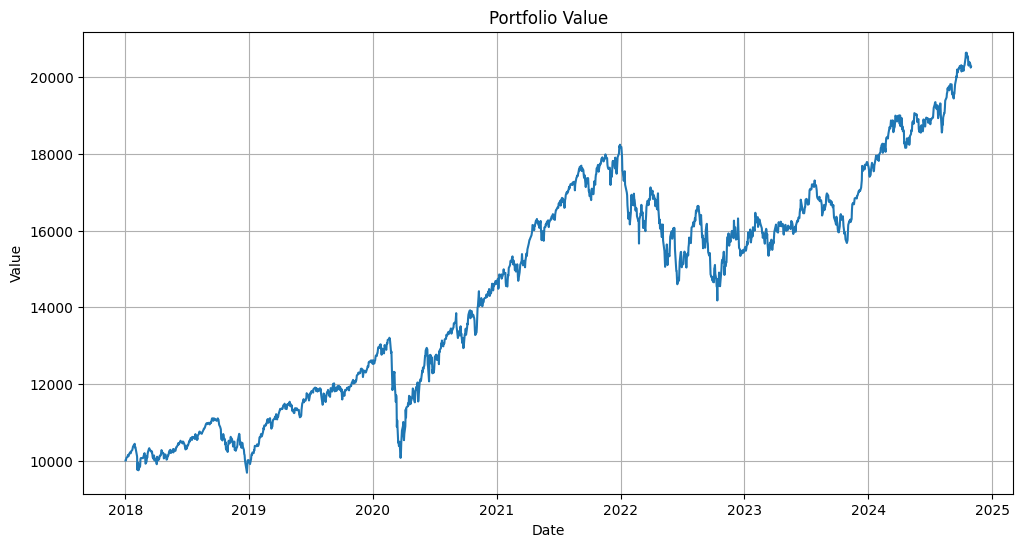

In [15]:
total_return_with_validate = df_portfolio_value_test_validate['value'][-1]/10000 - 1
print(f'Total return for test data with validation: {total_return_with_validate}')

sharpe_ratio = df_portfolio_value_test_validate['daily return'].mean()/df_portfolio_value_test_validate['daily return'].std()*np.sqrt(252)
print(f'Sharpe ratio for test data with validation: {sharpe_ratio}')

portfolio_value_series = df_portfolio_value_test_validate['value']
rolling_max = portfolio_value_series.expanding().max()
drawdowns = (portfolio_value_series - rolling_max) / rolling_max
max_drawdown = drawdowns.min() * 100
print(f'Maximum drawdown for test data with validation: {max_drawdown}%')

# Plot the portfolio value
plt.figure(figsize=(12,6))
plt.plot(df_portfolio_value_test_validate['value'])
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.show()


# Further Improvement on the Polynomial System

Based on the paper, we can see that the author use '2' as the band for the trading system. Now, we are going to see if we can adjust the coefficient to achieve better result.

In [16]:
upper_range = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
lower_range = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
ls_upper_range = []
ls_lower_range = []
ls_profit_loss_test = []
ls_profit_loss_validate = []
# Based on the validation period, we can find the optimal upper and lower range of 50 std for each stocks. and put the result in a dataframe
for uppder_coeff in upper_range:
    # print(uppder_coeff)
    for lower_coeff in lower_range:
        profitable_tickers = []
        for ticker in tickers_with_data:
            holder_validate[ticker]['4th 50 MA Upper'] = holder_validate[ticker]['4th 50 MA Average'] + uppder_coeff*residual_std_holder[ticker]
            holder_validate[ticker]['4th 50 MA Lower'] = holder_validate[ticker]['4th 50 MA Average'] - lower_coeff*residual_std_holder[ticker]
            holder_validate[ticker] = assign_signal(holder_validate[ticker])
            holder_validate[ticker] = assign_position(holder_validate[ticker])
            holder_validate[ticker]['profit/loss'] = 1000*(1+holder_validate[ticker]['position']*holder_validate[ticker]['price change']).cumprod() 
            
            holder_test[ticker]['4th 50 MA Upper'] = holder_test[ticker]['4th 50 MA Average'] + uppder_coeff*residual_std_holder[ticker]
            holder_test[ticker]['4th 50 MA Lower'] = holder_test[ticker]['4th 50 MA Average'] - lower_coeff*residual_std_holder[ticker]
            holder_test[ticker] = assign_signal(holder_test[ticker])
            holder_test[ticker] = assign_position(holder_test[ticker])
            holder_test[ticker]['profit/loss'] = 1000*(1+holder_test[ticker]['position']*holder_test[ticker]['price change']).cumprod()

            if holder_validate[ticker]['profit/loss'][-1] > 1000:
                profitable_tickers.append(ticker)
        profit_loss_validate = []
        profit_loss_test = []
        count_profit_test = 0
        count_loss_test = 0
        for ticker in profitable_tickers:
            profit_loss_validate.append(holder_validate[ticker]['profit/loss'][-1] - 1000)
            profit_loss_test.append(holder_test[ticker]['profit/loss'][-1] - 1000)
            if holder_test[ticker]['profit/loss'][-1] > 1000:
                count_profit_test += 1
            else:
                count_loss_test += 1
        ls_upper_range.append(uppder_coeff)
        ls_lower_range.append(lower_coeff)
        ls_profit_loss_test.append(sum(profit_loss_test))
        ls_profit_loss_validate.append(sum(profit_loss_validate))

In [17]:
# Create a dataframe to store the result
df_result = pd.DataFrame({'upper range': ls_upper_range, 'lower range': ls_lower_range, 'profit/loss_test': ls_profit_loss_test, 'profit/loss_validate': ls_profit_loss_validate, 'count_profit': count_profit_test, 'count_loss': count_loss_test})
df_result['total return test'] = df_result['profit/loss_test']/(df_result['count_profit']+df_result['count_loss'])/1000
df_result['total return validate'] = df_result['profit/loss_validate']/(df_result['count_profit']+df_result['count_loss'])/1000
df_result_by_test = df_result.sort_values(by='total return test', ascending=False)
df_result_by_validate = df_result.sort_values(by='total return validate', ascending=False)


In [18]:
df_result_by_test.head(10)

,upper range,lower range,profit/loss_test,profit/loss_validate,count_profit,count_loss,total return test,total return validate
6,0.5,3.5,368662.478492,92998.591470,144,35,2.059567,0.519545
5,0.5,3.0,359932.645045,90829.341319,144,35,2.010797,0.507426
4,0.5,2.5,350829.472534,89439.917381,144,35,1.959941,0.499664
13,1.0,3.5,350225.177065,84185.301604,144,35,1.956565,0.470309
3,0.5,2.0,348856.399502,87636.072416,144,35,1.948918,0.489587
12,1.0,3.0,345665.372688,82116.604347,144,35,1.931091,0.458752
2,0.5,1.5,342490.978816,84441.148357,144,35,1.913357,0.471738
11,1.0,2.5,335403.117800,81048.408764,144,35,1.873760,0.452784
0,0.5,0.5,329866.813970,74564.243836,144,35,1.842831,0.416560
1,0.5,1.0,326678.613111,80801.643122,144,35,1.825020,0.451406


In [19]:
df_result_by_validate.head(10)

,upper range,lower range,profit/loss_test,profit/loss_validate,count_profit,count_loss,total return test,total return validate
6,0.5,3.5,368662.478492,92998.591470,144,35,2.059567,0.519545
5,0.5,3.0,359932.645045,90829.341319,144,35,2.010797,0.507426
4,0.5,2.5,350829.472534,89439.917381,144,35,1.959941,0.499664
3,0.5,2.0,348856.399502,87636.072416,144,35,1.948918,0.489587
2,0.5,1.5,342490.978816,84441.148357,144,35,1.913357,0.471738
13,1.0,3.5,350225.177065,84185.301604,144,35,1.956565,0.470309
12,1.0,3.0,345665.372688,82116.604347,144,35,1.931091,0.458752
11,1.0,2.5,335403.117800,81048.408764,144,35,1.873760,0.452784
1,0.5,1.0,326678.613111,80801.643122,144,35,1.825020,0.451406
10,1.0,2.0,322898.766653,78524.708191,144,35,1.803904,0.438686


## Repick Stocks Annually

In [20]:
train_start_date = datetime.strptime('2010-01-01', '%Y-%m-%d').date()
ls_train_end_date = ['2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31']

ls_validation_start_date = ['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
ls_validation_end_date = ['2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']

ls_test_start_date = ['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01']
ls_test_end_date = ['2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31', '2024-10-31']

cumulative_profit_loss_test = 0

ls_year = ['2018', '2019', '2020', '2021', '2022', '2023', '2024']
ls_profit_loss = []
ls_count_profit = []
ls_count_loss = []
ls_count_no_trade = []
ls_initial_investment = []

initial_investment = 1000
portfolio_value = []

In [21]:
# Assume that we use the training data to train the model and use the validation data to select the profitable stocks on an annual basis.
# To simplify the process, we assume all the trade will be closed at the end of the test period if the position is still active.
# Ignore the opmization of the upper and lower range of 50 std for each stock for now
for i in range(len(ls_year)):
    # print(ls_year[i])
    train_end_date = datetime.strptime(ls_train_end_date[i], '%Y-%m-%d').date()
    validate_start_date = datetime.strptime(ls_validation_start_date[i], '%Y-%m-%d').date()
    validate_end_date = datetime.strptime(ls_validation_end_date[i], '%Y-%m-%d').date()
    test_start_date = datetime.strptime(ls_test_start_date[i], '%Y-%m-%d').date()
    test_end_date = datetime.strptime(ls_test_end_date[i], '%Y-%m-%d').date()

    holder_train = {}
    holder_validate = {}
    holder_test = {}
    tickers_with_data = []
    
    for ticker in tickers:
        holder_train[ticker] = holder[ticker].loc[train_start_date:train_end_date]
        holder_validate[ticker] = holder[ticker].loc[validate_start_date:validate_end_date]
        holder_test[ticker] = holder[ticker].loc[test_start_date:test_end_date]
    
        if not holder_train[ticker].empty and not holder_validate[ticker].empty and not holder_test[ticker].empty:
            tickers_with_data.append(ticker)
    
    # Train the model using the training data
    model = LinearRegression()
   # fourth_regression_holder = {}
    for ticker in tickers_with_data:
        # print(ticker)
        Y = holder_train[ticker]['open']
        X = holder_train[ticker][['50 MA', '50 MA^2','50 MA^3','50 MA^4']]
        model.fit(X, Y)
        residual_std_holder[ticker] = np.sqrt(mean_squared_error(Y, model.predict(X)))

        apply_model(model, holder_validate[ticker], residual_std_holder[ticker], 1)
        apply_model(model, holder_test[ticker], residual_std_holder[ticker], 1)
                
    # Select the profitable stocks in the validation data
    profitable_tickers = []
    for ticker in tickers_with_data:
        if holder_validate[ticker]['profit/loss'][-1] > 1:
            profitable_tickers.append(ticker)
    # Use the profitable stocks to apply the model to the test data
    
    # Use the profitable stocks to predict the test data
    profit_loss = []
    count_profit_test = 0
    count_loss_test = 0
    count_no_trade = 0
   
    stock_allocation = initial_investment/len(profitable_tickers)
    ls_initial_investment.append(initial_investment)
    for ticker in profitable_tickers:
        holder_test[ticker]['profit/loss'] = holder_test[ticker]['profit/loss']*stock_allocation 
        holder_test[ticker]['profit/loss'] = np.where(holder_test[ticker]['profit/loss'].isnull(), stock_allocation, holder_test[ticker]['profit/loss'])
        profit_loss.append(holder_test[ticker]['profit/loss'][-1] - stock_allocation )
        portfolio_value.append(holder_test[ticker]['profit/loss'])
        if holder_test[ticker]['profit/loss'][-1] > stock_allocation :
            count_profit_test += 1
        elif holder_test[ticker]['profit/loss'][-1] == stock_allocation :
            count_no_trade += 1
        else:
            #print('loss')
            count_loss_test += 1
    # Keep the daily profit/loss for each year in the list of portfolio value
    
    initial_investment = sum(profit_loss) + initial_investment   
    ls_profit_loss.append(sum(profit_loss))
    ls_count_profit.append(count_profit_test)
    ls_count_loss.append(count_loss_test)
    ls_count_no_trade.append(count_no_trade)


In [22]:
cumulative_profit_loss_test# Put the result in a dataframe
df_result = pd.DataFrame({'year': ls_year,  'profit/loss': ls_profit_loss,'count_profit': ls_count_profit, 'count_loss': ls_count_loss, 
                          'count_no_trade': ls_count_no_trade,'Balance at the year start': ls_initial_investment})
df_result['cumulative profit/loss (%)'] = 100*df_result['profit/loss']/df_result['Balance at the year start']
df_result = df_result[['year', 'profit/loss', 'Balance at the year start', 'cumulative profit/loss (%)', 'count_profit', 'count_loss', 'count_no_trade']]
df_result['Predicted profitable trade'] = df_result['count_profit'] + df_result['count_no_trade'] + df_result['count_loss']
df_result

,year,profit/loss,Balance at the year start,cumulative profit/loss (%),count_profit,count_loss,count_no_trade,Predicted profitable trade
0,2018,-2.202014,1000.000000,-0.220201,106,119,37,262
1,2019,220.986655,997.797986,22.147435,76,18,11,105
2,2020,194.334352,1218.784641,15.944929,201,109,11,321
3,2021,265.901913,1413.118993,18.816668,178,50,52,280
4,2022,-167.051693,1679.020907,-9.949352,64,195,21,280
5,2023,24.211068,1511.969213,1.601294,36,46,14,96
6,2024,256.719170,1536.180281,16.711526,142,61,10,213


In [23]:
# Transform the portfolio value from a dictionary to a dataframe
df_portfolio_value = pd.DataFrame(portfolio_value)
df_portfolio_value = df_portfolio_value.T
df_portfolio_value['value'] = df_portfolio_value.sum(axis=1,skipna=True)
df_portfolio_value = df_portfolio_value[['value']]
df_portfolio_value

,value
2018-01-02,1000.000000
2018-01-03,1000.000000
2018-01-04,1005.352654
2018-01-05,1007.647670
2018-01-08,1009.755892
...,...
2024-10-24,1795.774697
2024-10-25,1804.632547
2024-10-28,1800.147331
2024-10-29,1792.337199


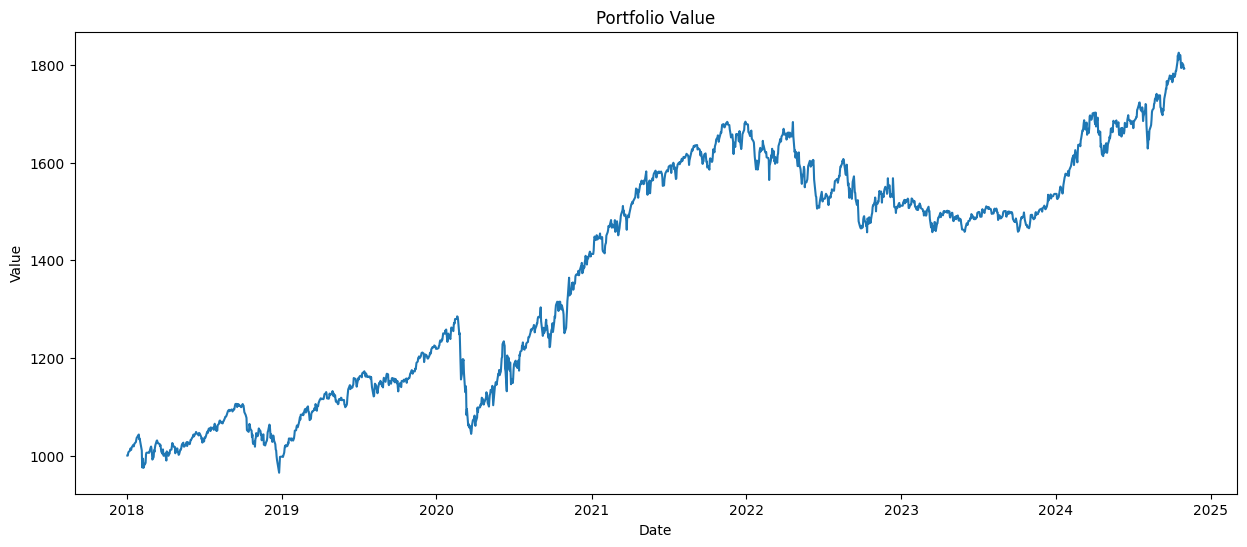

In [24]:
# Plot the portfolio value
plt.figure(figsize=(15, 6))
plt.plot(df_portfolio_value['value'])
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [25]:
import numpy as np
# Calculate daily returns
df_portfolio_value['daily_returns'] = df_portfolio_value['value'].pct_change()

# Calculate metrics
# 1. Annual Return
annual_return = (df_portfolio_value['daily_returns'].mean() * 252) * 100  # 252 trading days

# 2. Sharpe Ratio (assuming risk-free rate of 0.02 or 2%)
rf = 0.02  # risk free rate
excess_returns = df_portfolio_value['daily_returns'] - rf/252
sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# 4. Maximum Drawdown
portfolio_value_series = df_portfolio_value['value']
rolling_max = portfolio_value_series.expanding().max()
drawdowns = (portfolio_value_series - rolling_max) / rolling_max
max_drawdown = drawdowns.min() * 100

# Print results
print(f"Performance Metrics:")
print(f"Annual Return: {annual_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

Performance Metrics:
Annual Return: 9.23%
Sharpe Ratio: 0.63
Maximum Drawdown: -18.73%


Based on the result, we can see that the coefficient of the standard deviation may influence the portfolio performance
However, repicking the potential profitable stocks annually will lead to worse performance.